In [23]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
df_1 = pd.read_csv("/content/drive/MyDrive/Analyst Sentiment/Tiki_Comments.csv")
df_2 = pd.read_csv("/content/drive/MyDrive/Analyst Sentiment/Tiki_Comments_2.csv")
df_3 = pd.read_csv("/content/drive/MyDrive/Analyst Sentiment/Tiki_Comments_3.csv")
df_4 = pd.read_csv("/content/drive/MyDrive/Analyst Sentiment/Tiki_Comments_4.csv")
df = pd.concat([df_1, df_2, df_3, df_4], ignore_index=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Processing Data

##Làm sạch dữ liệu

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69864 entries, 0 to 69863
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             0 non-null      float64
 1   title          69864 non-null  object 
 2   content        45688 non-null  object 
 3   thank_count    69864 non-null  int64  
 4   customer_id    69864 non-null  int64  
 5   rating         69864 non-null  int64  
 6   customer_name  69838 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 3.7+ MB


###Loại bỏ cột id không cần thiết và xử lý giá trị null, duplicates

In [25]:
#Xóa dữ liệu trùng lặp
df = df.drop_duplicates(subset=['customer_id','content'], keep='first')
#Xóa cột id và thank_count, customer_name , customer_id vì không cần thiết
df = df.drop(columns=['id'])
df = df.drop(columns=['thank_count'])
df = df.drop(columns=['customer_name'])
df = df.drop(columns=['customer_id'])

# Xoá những dòng bị thiếu ở cột 'content' (quan trọng để xử lý text)
df = df.dropna(subset=['content'])
# Thay thế NaN ở 'customer_name' bằng chuỗi trống (nếu cần giữ lại cột này)
# df['customer_name'] = df['customer_name'].fillna("")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31678 entries, 0 to 69863
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    31678 non-null  object
 1   content  31678 non-null  object
 2   rating   31678 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 989.9+ KB


###Load các danh sách emoji, stopword, từ viết tắt để chuẩn bị clean data

In [26]:
import re

#Danh sách emoji cần xóa
emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Mặt cười, cảm xúc
        u"\U0001F300-\U0001F5FF"  # Biểu tượng thiên nhiên, đối tượng
        u"\U0001F680-\U0001F6FF"  # Biểu tượng giao thông
        u"\U0001F1E0-\U0001F1FF"  # Cờ quốc gia
        u"\U00002702-\U000027B0"  # Ký hiệu dạng hình
        u"\U000024C2-\U0001F251"  # Ký hiệu đóng khung
        u"\U0001F926-\U0001F937"  # Hành động, cử chỉ
        u"\U00010000-\U0010FFFF" # Các ký tự bổ sung
        u"\u200d"                 # Nối ký tự (zero width joiner)
        u"\u2640-\u2642"          # Ký hiệu giới tính
        u"\u2600-\u2B55"          # Biểu tượng đa dạng khác
        u"\u23cf"                 # Biểu tượng đẩy đĩa
        u"\u23e9"                 # Tua nhanh
        u"\u231a"                 # Đồng hồ
        u"\u3030"                 # Dấu ngoằn ngoèo
        u"\ufe0f"                 # Bộ chọn kiểu hiển thị
        "]+", flags=re.UNICODE
)

#Load danh sách các stop word
vietnamese_stopwords = set(open('/content/drive/MyDrive/Analyst Sentiment/vietnamese-stopwords.txt', encoding='utf-8').read().splitlines())

#Load danh sách các từ viết tắt hay sử dụng
short_word_dict = {
    "ko": "không",
    "kg": "không",
    "khong": "không",
    "k": "không",
    "kh": "không",
    "cx": "cũng",
    "mik": "mình",
    "mn": "mọi người",
    "bt": "bình thường",
    "nv": "nhân viên",
    "sp": "sản phẩm",
    "đc": "được",
    "dc": "được",
    "đk": "điều khoản",
    "đt": "điện thoại",
    "j": "gì",
    "vs": "với",
    "hok": "không",
    "lun": "luôn",
    "z": "gì",
    "zậy": "gì vậy",
    "thik": "thích",
    "hum": "hôm",
    "wa": "qua",
    "m": "mình",
    "mk": "mình",
    "bn": "bạn",
    "ok": "ổn"
}

###Trực quan hóa stop word

In [7]:
!pip install underthesea
!pip install wordcloud underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 83.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 62.4 MB/s eta 0:00:00


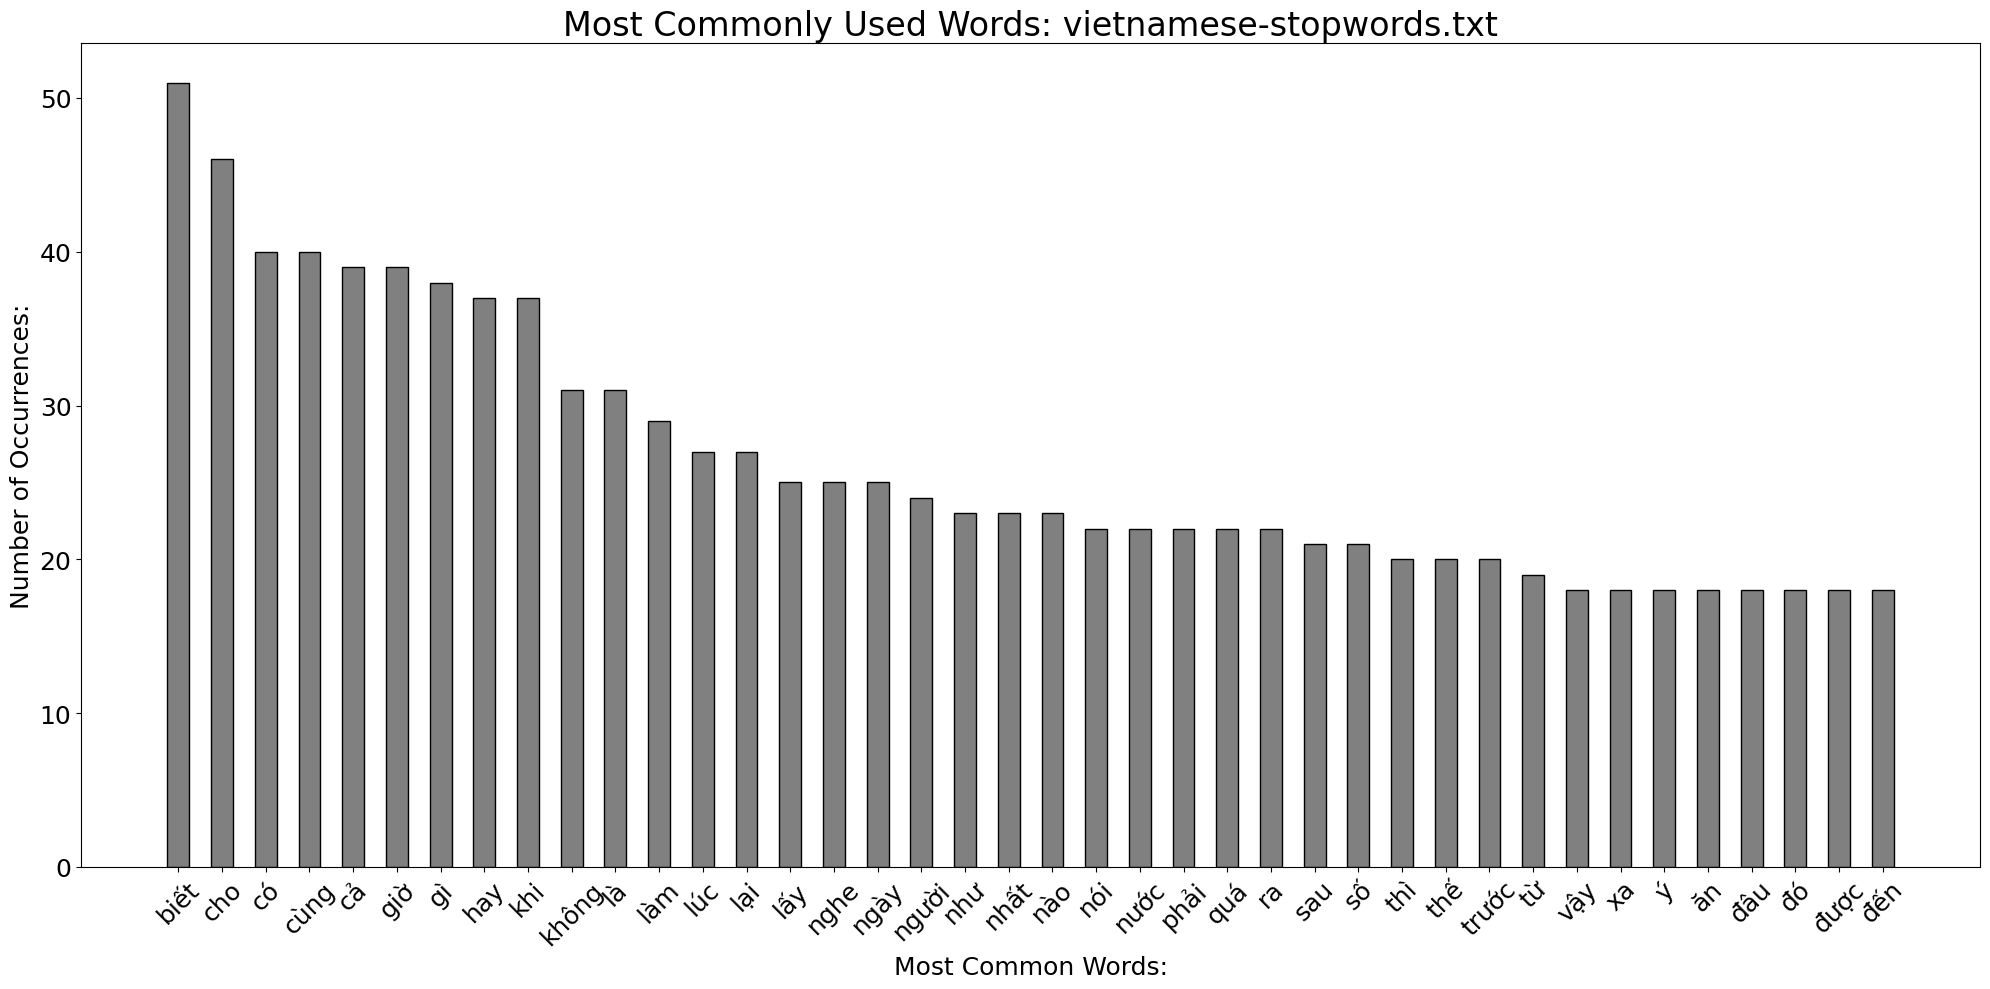

In [27]:
import numpy as np
from matplotlib import pyplot as plt

def plotWordFrequency(vietnamese_file):
    # Đọc file stopword
    with open(vietnamese_file, 'r', encoding='utf-8') as f:
        words = [x for y in [l.strip().split() for l in f.readlines()] for x in y]

    # Đếm số lần xuất hiện xắp xếp theo thứ tự
    data = sorted([(w, words.count(w)) for w in set(words)], key=lambda x: x[1], reverse=True)[:40]

    most_words = [x[0] for x in data]
    times_used = [x[1] for x in data]

    # Vẽ biểu đồ
    plt.figure(figsize=(20, 10))
    plt.bar(x=sorted(most_words), height=times_used, color='grey', edgecolor='black', width=.5)
    plt.xticks(rotation=45, fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('Most Common Words:', fontsize=18)
    plt.ylabel('Number of Occurrences:', fontsize=18)
    plt.title('Most Commonly Used Words: %s' % vietnamese_file.split('/')[-1], fontsize=24)
    plt.tight_layout()
    plt.show()
plotWordFrequency('/content/drive/MyDrive/Analyst Sentiment/vietnamese-stopwords.txt')


###Hàm clean data

In [28]:
from underthesea import word_tokenize # Bộ ngữ nghĩa
from underthesea import text_normalize #Chuẩn hóa văn bản

def clean_data(text):
    #Chuyển thành chữ thường
    text = text.lower()

    # Rút gọn các ký tự lặp lại 3 lần trở lên (vd: okkkkk → ok)
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Xóa emoji
    text = emoji_pattern.sub(r'', text)

    # Xóa ký tự đặc biệt
    text = re.sub(r'[^\w\s]', ' ', text)

    #Chuẩn hóa văn bảng các dấu câu
    text = text_normalize(text)

    # Chuẩn hóa từ viết tắt (trước khi xóa ký tự đặc biệt)
    words = text.split()
    words = [short_word_dict.get(word, word) for word in words]
    text = ' '.join(words)

    # Ghép từ phủ định để không mất nghĩa
    # text = re.sub(r"không\s+(tốt|hài lòng|ổn|đẹp|được|hợp lý|xứng đáng|hay|ok|phù hợp|nhanh|sạch|hợp|thích|ổn)",
    #           lambda m: "không_" + m.group(1).replace(" ", "_"),
    #           text)

     # Tách từ và loại bỏ dấu "_"  text = ' '.join(word_tokenize(text))
    text = word_tokenize(text, format="text")
    #Xóa stop word (riêng title không thực hiện hành động này)
    #text = ' '.join([word for word in text.split() if word not in vietnamese_stopwords])

    return text

##Chuẩn hóa dữ liệu



In [29]:
#Chuẩn hóa cột content
df['clean_content'] = df['content'].map(lambda text: clean_data(text))

#Chuẩn hóa cột title
df['title'] = df['title'].map(lambda text: clean_data(text))
df['title'] = df['title'].str.replace('_', ' ')
# Final check
df.head(20)

,title,content,rating,clean_content
0,cực kì hài lòng,Sách đẹp. Thơ có bài ngắn bài dài. Hay!,5,sách đẹp_thơ có bài ngắn bài dài hay
1,cực kì hài lòng,Huhu sách xinh xỉu✨✨✨,5,huhu sách xinh_xỉu
10,cực kì hài lòng,Sách thiết kế đẹp. Bố cục tốt. Rất thích hợp c...,5,sách thiết_kế đẹp bố cục tốt rất thích_hợp cho...
11,cực kì hài lòng,"Shop đóng gói cẩn thận, giao hàng nhanh. Mình ...",5,shop đóng_gói cẩn_thận giao hàng nhanh mình rấ...
12,cực kì hài lòng,Shop tôn trọng khách hàng bằng nhiều hình thức...,5,shop tôn_trọng khách_hàng bằng nhiều hình_thức...
13,hài lòng,Cho mình xin hỉnh chụp lúc giao hàng,4,cho mình xin hỉnh chụp lúc giao hàng
14,cực kì hài lòng,Có kèm audio sao mình k thấy nhỉ,5,có kèm audio sao mình không thấy nhỉ
20,cực kì hài lòng,"Cuốn này của cô Tư khá mỏng, nhưng hay lắm ạ!!...",5,cuốn này của cô tư khá mỏng nhưng hay lắm ạ sá...
21,cực kì hài lòng,giao nhanh 5g kém chốt 6g đã nhận đc,5,giao nhanh 5 g kém chốt 6 g đã nhận được
30,cực kì hài lòng,Cực kỳ hài lòng\r\nSản phẩm có chất lượng đúng...,5,cực_kỳ hài_lòng sản_phẩm có chất_lượng đúng nh...


##Phân tích dữ liệu

###Mức độ tập trung của các từ

Number of words: 29687
Most common words: [('ổn', 460), ('tốt', 251), ('đẹp', 76), ('sản_phẩm tốt', 75), ('good', 73), ('hài_lòng', 52), ('sản_phẩm ổn', 44), ('rất tốt', 40), ('rất hài_lòng', 33), ('giao hàng nhanh', 30), ('tuyệt_vời', 28), ('chất_lượng tốt', 27), ('tot', 23), ('ngon', 21), ('hàng ổn', 20)]


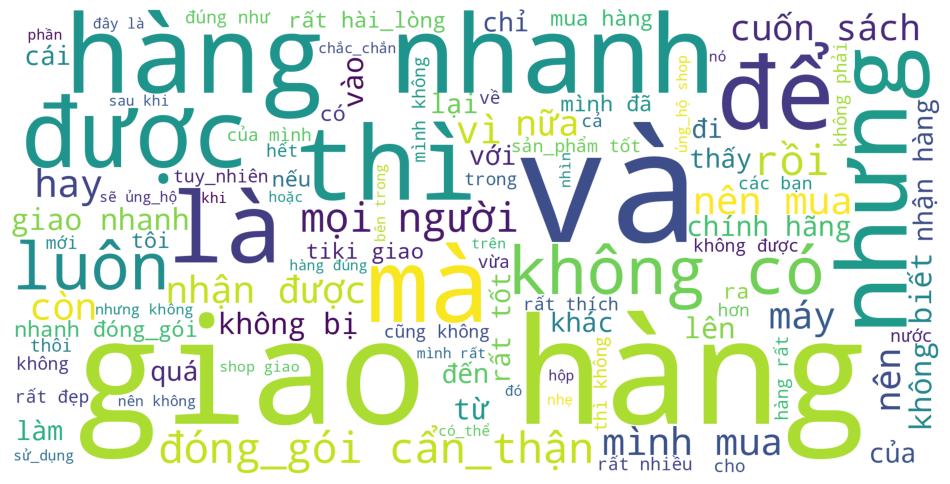

In [30]:
import nltk
from wordcloud import WordCloud
# Create bag-of-words
all_words = [token for token in df['clean_content'].tolist() if token and token != '']

corpus=' '.join(all_words)
all_words = nltk.FreqDist(all_words)

# Print the total number of words and the 15 most common words
print('Number of words: {}'.format(len(all_words)))
print('Most common words: {}'.format(all_words.most_common(15)))

plt.figure(figsize=(12,8))
word_cloud = WordCloud(max_words=100,background_color ="white",
                               width=2000,height=1000,mode="RGB").generate(corpus)
plt.axis("off")
plt.imshow(word_cloud)

###Phân tích phân phối độ dài câu trong các đánh giá của khách hàng

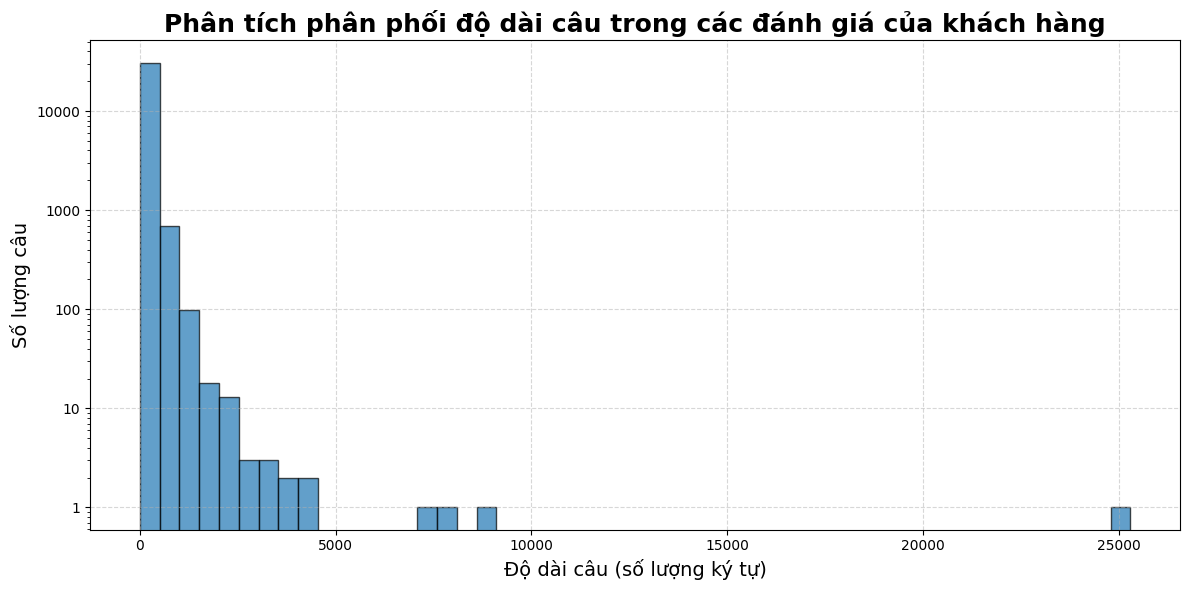

In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Tính độ dài câu
lengths = df['clean_content'].apply(len)
plt.figure(figsize=(12, 6))
plt.hist(lengths, bins=50, edgecolor='k', alpha=0.7)


plt.title('Phân tích phân phối độ dài câu trong các đánh giá của khách hàng', fontsize=18, fontweight='bold')
plt.xlabel('Độ dài câu (số lượng ký tự)', fontsize=14)
plt.ylabel('Số lượng câu', fontsize=14)

# Định dạng trục y
plt.yscale('log')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{int(x)}'))

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


### Phân tích dữ liệu phân bố giữa label và rating

<ipython-input-32-1c5b1455059d>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], y=top_titles.index, x=top_titles.values, palette='Set2')


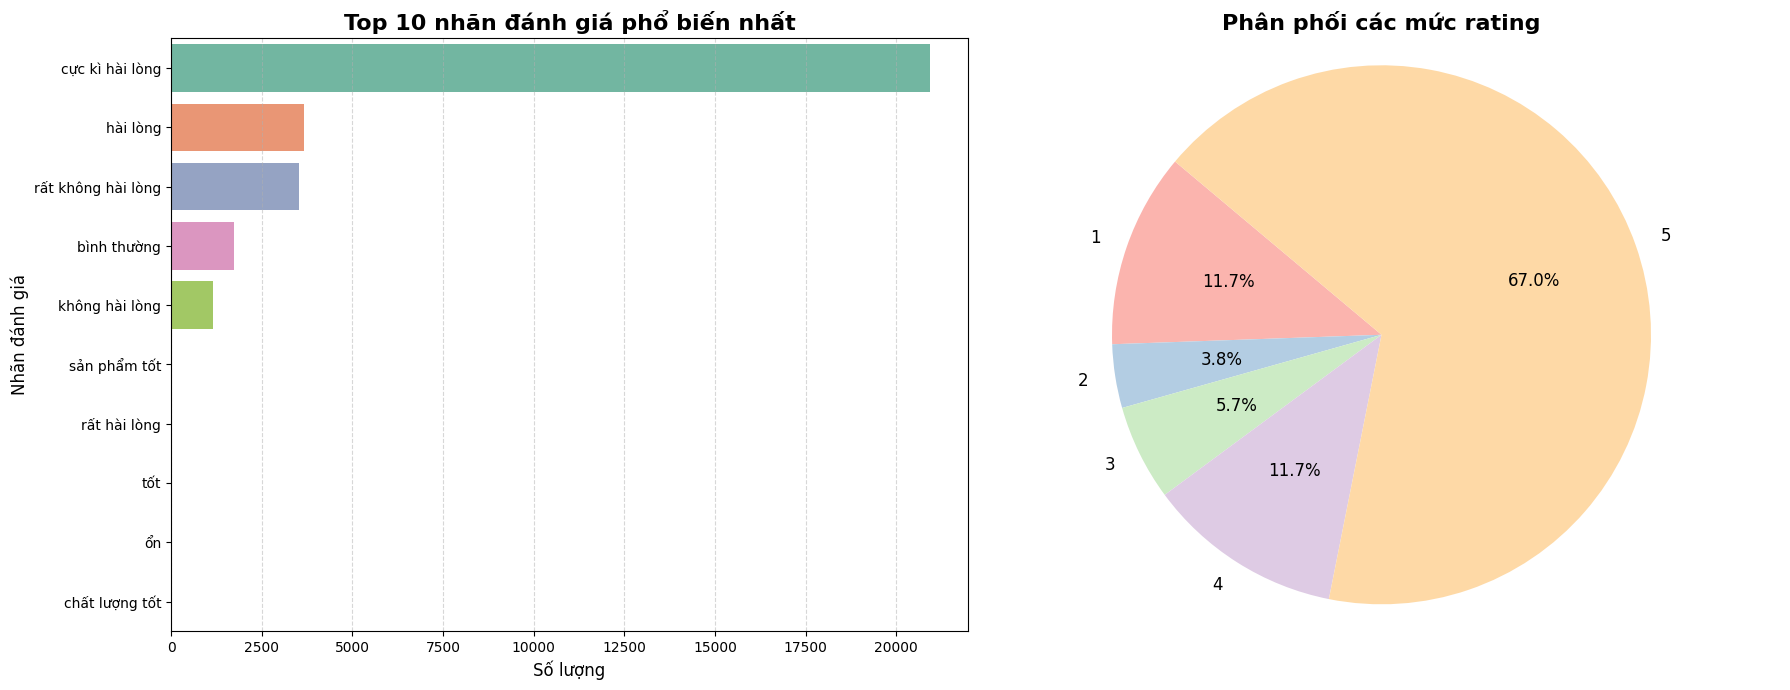

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'DejaVu Sans'

# Dữ liệu
top_titles = df['title'].value_counts().nlargest(10)
rating_counts = df['rating'].value_counts().sort_index()

# Tạo figure với 2 subplot nằm cạnh nhau
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Biểu đồ cột ngang ---
sns.barplot(ax=axes[0], y=top_titles.index, x=top_titles.values, palette='Set2')
axes[0].set_title('Top 10 nhãn đánh giá phổ biến nhất', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Số lượng', fontsize=12)
axes[0].set_ylabel('Nhãn đánh giá', fontsize=12)
axes[0].grid(axis='x', linestyle='--', alpha=0.5)

# --- Biểu đồ tròn ---
colors = sns.color_palette('Pastel1', len(rating_counts))
axes[1].pie(
    rating_counts,
    labels=rating_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 12}
)
axes[1].set_title('Phân phối các mức rating', fontsize=16, fontweight='bold')
axes[1].axis('equal')

plt.tight_layout()
plt.show()


##Cân bằng mẫu

###Cân bằng mẫu với 2 nhãn

####Gồm thành 2 nhãn

In [33]:
def chuan_hoa_title(row):
    if row['rating'] == 5 or row['rating'] == 4:
        return 'cực kỳ hài lòng'
    else:
        return 'không hài lòng'

df['title'] = df.apply(chuan_hoa_title, axis=1)
print(df['title'].value_counts())

title
cực kỳ hài lòng    24951
không hài lòng      6727
Name: count, dtype: int64


#####Trực quan dữ liệu 2 nhãn

Number of words in Cực kỳ hài lòng: 24916
Most common words in Cực kỳ hài lòng: [('ổn', 460), ('tốt', 251), ('đẹp', 76), ('sản_phẩm tốt', 75), ('good', 73), ('hài_lòng', 52), ('sản_phẩm ổn', 44), ('rất tốt', 40), ('rất hài_lòng', 33), ('giao hàng nhanh', 30), ('tuyệt_vời', 28), ('chất_lượng tốt', 27), ('tot', 23), ('ngon', 21), ('hàng ổn', 20)]
Number of words in Không hài lòng: 6727
Most common words in Không hài lòng: [('sản_phẩm không như quảng_cáo', 4), ('sản_phẩm không như mong_đợi', 3), ('chưa nhận hàng', 2), ('giá trên tem là 350 không mà bán tận 451 không như đảo', 2), ('bình_thường', 2), ('sản_phẩm không đúng như quảng_cáo', 2), ('chất_lượng vải không giống như hình', 2), ('phần dán keo bị hở nhé dễ bị bung keo phần giấy lắm', 1), ('cuốn chat gpt ứng_dụng trong công_việc quá chán nội_dung không rõ_ràng cuốn chat gpt thực_chiến thì hay 2 cuốn còn lại thì chưa đọc', 1), ('nội_dung không có gì đặc_sắc kiến_thức đã cũ so với hiện_tại', 1), ('nhiều câu giống như là máy dịch đọc rất

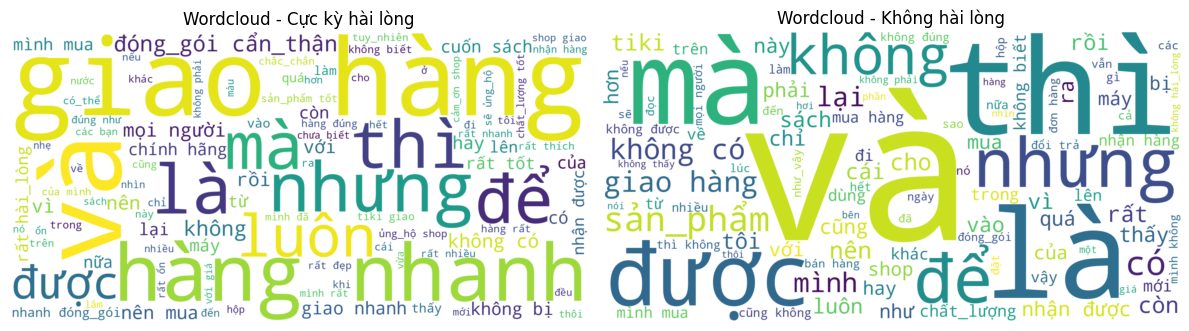

In [34]:
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Tạo danh sách từ cho 'cực kỳ hài lòng' và 'không hài lòng'
happy_words = [token for token in df[df['title'] == 'cực kỳ hài lòng']['clean_content'].tolist() if token and token != '']
unhappy_words = [token for token in df[df['title'] == 'không hài lòng']['clean_content'].tolist() if token and token != '']

# Tạo corpus từ các từ trong từng nhóm
happy_corpus = ' '.join(happy_words)
unhappy_corpus = ' '.join(unhappy_words)

# Tạo frequency distribution cho mỗi nhóm
happy_freq_dist = nltk.FreqDist(happy_words)
unhappy_freq_dist = nltk.FreqDist(unhappy_words)

# In tổng số từ và 15 từ phổ biến nhất cho từng nhóm
print('Number of words in Cực kỳ hài lòng: {}'.format(len(happy_words)))
print('Most common words in Cực kỳ hài lòng: {}'.format(happy_freq_dist.most_common(15)))

print('Number of words in Không hài lòng: {}'.format(len(unhappy_words)))
print('Most common words in Không hài lòng: {}'.format(unhappy_freq_dist.most_common(15)))

# Vẽ wordcloud cho 'cực kỳ hài lòng'
plt.figure(figsize=(12, 8))

# Wordcloud cho nhóm 'cực kỳ hài lòng'
plt.subplot(1, 2, 1)
word_cloud_happy = WordCloud(max_words=100, background_color="white", width=2000, height=1000, mode="RGB").generate(happy_corpus)
plt.imshow(word_cloud_happy, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud - Cực kỳ hài lòng")

# Wordcloud cho nhóm 'không hài lòng'
plt.subplot(1, 2, 2)
word_cloud_unhappy = WordCloud(max_words=100, background_color="white", width=2000, height=1000, mode="RGB").generate(unhappy_corpus)
plt.imshow(word_cloud_unhappy, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud - Không hài lòng")

plt.tight_layout()
plt.show()


####Chia đều tập dữ liệu

In [37]:
df_cuc_ky_hai_long = df[df['title'] == 'cực kỳ hài lòng'].sample(n=6727, replace=False, random_state=42)
df_khong_hai_long = df[df['title'] == 'không hài lòng']
df_balanced_2_label = pd.concat([df_cuc_ky_hai_long, df_khong_hai_long], axis=0)

df_balanced_2_label = df_balanced_2_label.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced_2_label['title'].value_counts())

df_balanced_2_label.to_csv('/content/drive/MyDrive/Analyst Sentiment/df_balanced_2_label.csv', index=False)

title
cực kỳ hài lòng    6727
không hài lòng     6727
Name: count, dtype: int64


####So sánh

<ipython-input-36-ad69aa614258>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x=before_balance.index, y=before_balance.values, palette='Set2')
<ipython-input-36-ad69aa614258>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x=after_balance.index, y=after_balance.values, palette='Pastel1')


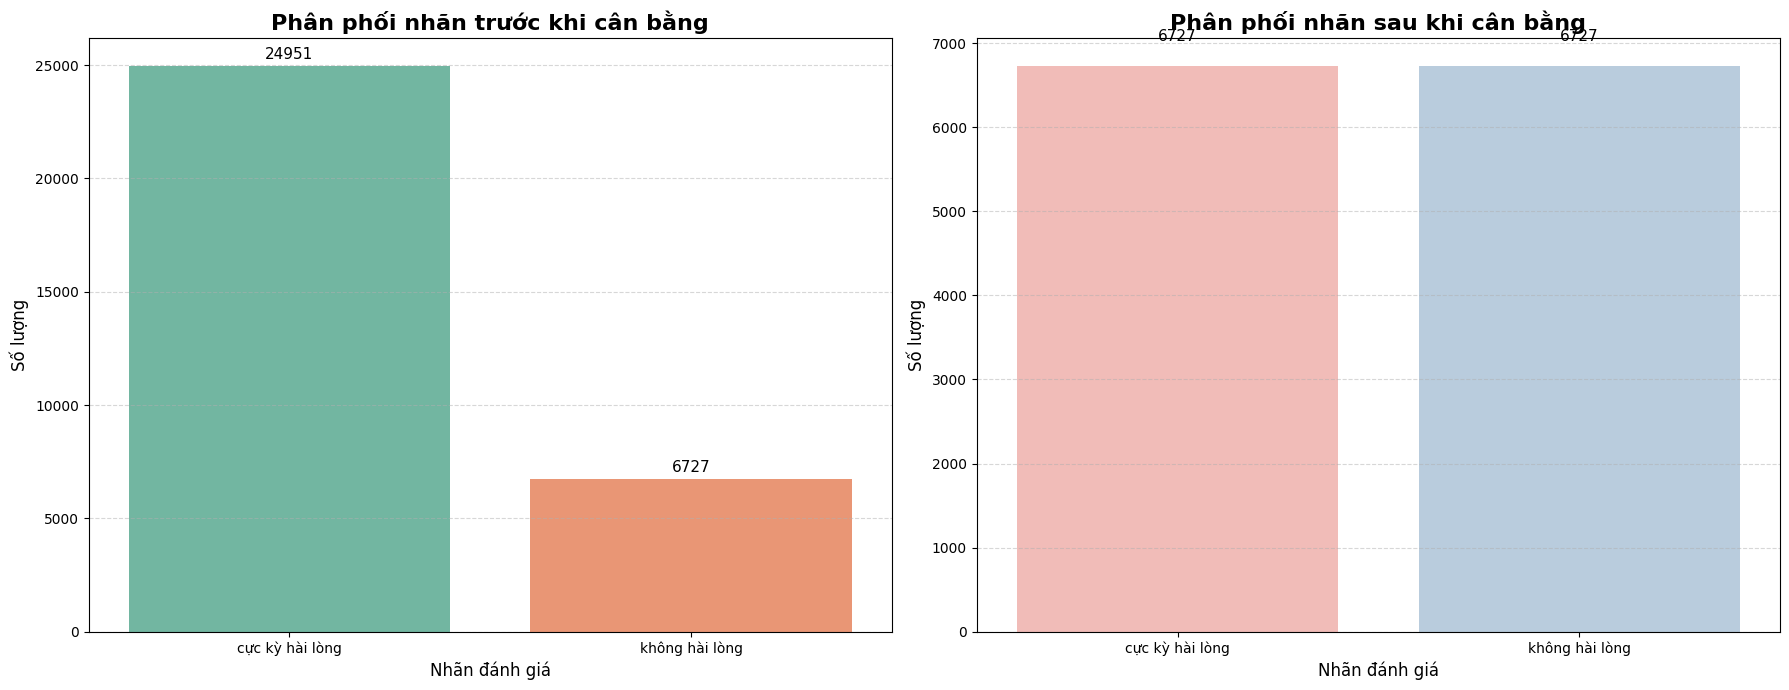

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'DejaVu Sans'

# Dữ liệu
before_balance = df['title'].value_counts().sort_index()
after_balance = df_balanced_2_label['title'].value_counts().sort_index()

# Tạo figure với 2 subplot nằm cạnh nhau
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- Biểu đồ cột đứng: Trước khi cân bằng ---
sns.barplot(ax=axes[0], x=before_balance.index, y=before_balance.values, palette='Set2')
axes[0].set_title('Phân phối nhãn trước khi cân bằng', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Nhãn đánh giá', fontsize=12)
axes[0].set_ylabel('Số lượng', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# Hiển thị số liệu trên cột
for i, v in enumerate(before_balance.values):
    axes[0].text(i, v + 300, str(v), ha='center', fontsize=11)

# --- Biểu đồ cột đứng: Sau khi cân bằng ---
sns.barplot(ax=axes[1], x=after_balance.index, y=after_balance.values, palette='Pastel1')
axes[1].set_title('Phân phối nhãn sau khi cân bằng', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Nhãn đánh giá', fontsize=12)
axes[1].set_ylabel('Số lượng', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Hiển thị số liệu trên cột
for i, v in enumerate(after_balance.values):
    axes[1].text(i, v + 300, str(v), ha='center', fontsize=11)

plt.tight_layout()
plt.show()


####Chia tập dữ liệu training và test thành 80-20

In [19]:
from sklearn.model_selection import train_test_split
train_sentences_2_label, test_sentences_2_label, train_labels_2_label, test_labels_2_label = train_test_split(
    df_balanced_2_label['clean_content'],
    df_balanced_2_label['title'],
    test_size=0.1,
    random_state=42
)

###Cân bằng mẫu với 3 nhãn

####Gộp thành 3 nhãn chính

In [18]:
def chuan_hoa_title(row):
    if row['rating'] == 5 or row['rating'] == 4:
        return 'cực kỳ hài lòng'
    elif row['rating'] == 3:
        return 'bình thường'
    else:  # rating == 1 và 2
        return 'không hài lòng'

df['title'] = df.apply(chuan_hoa_title, axis=1)
print(df['title'].value_counts())

title
cực kỳ hài lòng    24951
không hài lòng      4906
bình thường         1821
Name: count, dtype: int64


#####Trực quan hóa 3 nhãn

Number of words in Cực kỳ hài lòng: 24916
Most common words in Cực kỳ hài lòng: [('ổn', 460), ('tốt', 251), ('đẹp', 76), ('sản_phẩm tốt', 75), ('good', 73), ('hài_lòng', 52), ('sản_phẩm ổn', 44), ('rất tốt', 40), ('rất hài_lòng', 33), ('giao hàng nhanh', 30), ('tuyệt_vời', 28), ('chất_lượng tốt', 27), ('tot', 23), ('ngon', 21), ('hàng ổn', 20)]
Number of words in Bình thường: 1821
Number of words in Không hài lòng: 4906
Most common words in Không hài lòng: [('sản_phẩm không như quảng_cáo', 3), ('chưa nhận hàng', 2), ('giá trên tem là 350 không mà bán tận 451 không như đảo', 2), ('sản_phẩm không đúng như quảng_cáo', 2), ('chất_lượng vải không giống như hình', 2), ('sản_phẩm không như mong_đợi', 2), ('phần dán keo bị hở nhé dễ bị bung keo phần giấy lắm', 1), ('cuốn chat gpt ứng_dụng trong công_việc quá chán nội_dung không rõ_ràng cuốn chat gpt thực_chiến thì hay 2 cuốn còn lại thì chưa đọc', 1), ('nội_dung không có gì đặc_sắc kiến_thức đã cũ so với hiện_tại', 1), ('nhiều câu giống như là

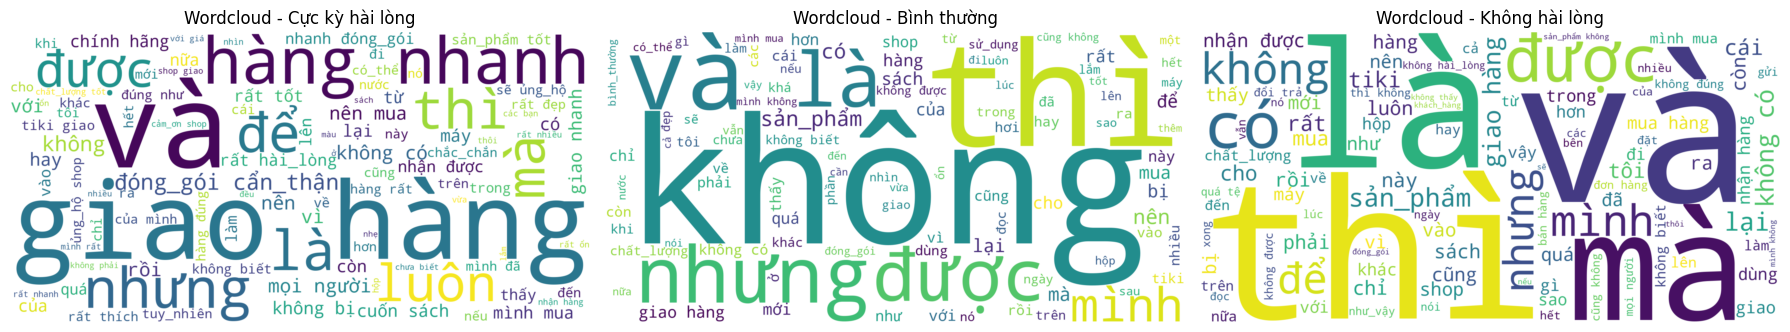

In [ ]:
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Tạo danh sách từ cho 'cực kỳ hài lòng' và 'không hài lòng'
happy_words = [token for token in df[df['title'] == 'cực kỳ hài lòng']['clean_content'].tolist() if token and token != '']
unhappy_words = [token for token in df[df['title'] == 'không hài lòng']['clean_content'].tolist() if token and token != '']
normal_words = [token for token in df[df['title'] == 'bình thường']['clean_content'].tolist() if token and token != '']

# Tạo corpus từ các từ trong từng nhóm
happy_corpus = ' '.join(happy_words)
unhappy_corpus = ' '.join(unhappy_words)
normal_corpus = ' '.join(normal_words)

# Tạo frequency distribution cho mỗi nhóm
happy_freq_dist = nltk.FreqDist(happy_words)
unhappy_freq_dist = nltk.FreqDist(unhappy_words)
normal__freq_dist = nltk.FreqDist(normal_words)

# In tổng số từ và 15 từ phổ biến nhất cho từng nhóm
print('Number of words in Cực kỳ hài lòng: {}'.format(len(happy_words)))
print('Most common words in Cực kỳ hài lòng: {}'.format(happy_freq_dist.most_common(15)))
print('Number of words in Bình thường: {}'.format(len(normal_words)))

print('Number of words in Không hài lòng: {}'.format(len(unhappy_words)))
print('Most common words in Không hài lòng: {}'.format(unhappy_freq_dist.most_common(15)))
print('Most common words in Bình thường: {}'.format(normal__freq_dist.most_common(15)))

# Vẽ wordcloud cho cả 3 nhóm
plt.figure(figsize=(18, 10))

# Wordcloud cho nhóm 'cực kỳ hài lòng'
plt.subplot(1, 3, 1)
word_cloud_happy = WordCloud(max_words=100, background_color="white", width=2000, height=1000, mode="RGB").generate(happy_corpus)
plt.imshow(word_cloud_happy, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud - Cực kỳ hài lòng")

# Wordcloud cho nhóm 'bình thường'
plt.subplot(1, 3, 2)
word_cloud_normal = WordCloud(max_words=100, background_color="white", width=2000, height=1000, mode="RGB").generate(normal_corpus)
plt.imshow(word_cloud_normal, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud - Bình thường")


# Wordcloud cho nhóm 'không hài lòng'
plt.subplot(1, 3, 3)
word_cloud_unhappy = WordCloud(max_words=100, background_color="white", width=2000, height=1000, mode="RGB").generate(unhappy_corpus)
plt.imshow(word_cloud_unhappy, interpolation="bilinear")
plt.axis("off")
plt.title("Wordcloud - Không hài lòng")

plt.tight_layout()
plt.show()


In [ ]:
df_cuc_ky_hai_long = df[df['title'] == 'cực kỳ hài lòng'].sample(n=2200, replace=False, random_state=42)
df_binh_thuong = df[df['title'] == 'bình thường']
df_khong_hai_long = df[df['title'] == 'không hài lòng'].sample(n=2200, replace=False, random_state=42)

df_balanced_3_label = pd.concat([df_cuc_ky_hai_long, df_binh_thuong, df_khong_hai_long], axis=0)
df_balanced_3_label = df_balanced_3_label.sample(frac=1, random_state=42).reset_index(drop=True)

print(df_balanced_3_label['title'].value_counts())

title
cực kỳ hài lòng    2200
không hài lòng     2200
bình thường        1821
Name: count, dtype: int64


####Chia tập dữ liệu huấn luyện và kiểm tra 80 - 20

In [ ]:
from sklearn.model_selection import train_test_split
train_sentences_3_label, test_sentences_3_label, train_labels_3_label, test_labels_3_label = train_test_split(
    df_balanced_3_label['clean_content'],
    df_balanced_3_label['title'],
    test_size=0.1,
    random_state=42
)

####Tăng cường mẫu "Bình Thường"

In [ ]:
from sklearn.utils import resample

# Tách các đánh giá trung lập ("bình thường") và hài lòng ("cực kỳ hài lòng")
neutral_indices = np.where(train_labels_3_label == "bình thường")[0]
satisfied_indices = np.where(train_labels_3_label == "cực kỳ hài lòng")[0]

# Tính số lượng mẫu cần sao chép để cân bằng giữa "không hài lòng" và "bình thường"
oversample_size = len(satisfied_indices) - len(neutral_indices)

# Nếu oversample_size > 0 thì tiến hành over-sampling
if oversample_size > 0:
  # Lấy ngẫu nhiên các mẫu "bình thường" để nhân bản (cho đủ số lượng cần thiết)
   oversampled_neutral_indices = resample(neutral_indices,
                                       replace=True,
                                       n_samples=oversample_size)

   # Kết hợp các câu gốc và câu được over-sample
   oversampled_neutral_sentences = np.array(train_sentences_3_label)[oversampled_neutral_indices]

   train_sentences_oversampled = np.concatenate([train_sentences_3_label, oversampled_neutral_sentences], axis=0)
   train_labels_oversampled = np.concatenate([train_labels_3_label, np.array(["bình thường"] * oversample_size)], axis=0)


   train_labels_oversampled = train_labels_oversampled.astype(str)

    # Đếm số lượng của từng nhãn trong dữ liệu đã cân bằng
   unique_labels, counts = np.unique(train_labels_oversampled, return_counts=True)
   for label, count in zip(unique_labels, counts):
       print(f"Label {label}: {count}")

else:
    print("Dữ liệu đã cân bằng sẵn.")


Label bình thường: 1974
Label cực kỳ hài lòng: 1974
Label không hài lòng: 1975


In [ ]:
    df_oversampled = pd.DataFrame({
        'content': train_sentences_oversampled,
        'label': train_labels_oversampled
    })
    df_binh_thuong = df_oversampled[df_oversampled['label'] == "bình thường"]
    df_binh_thuong

,content,label
1,sữa tắm lỏng quẹt không đặc_sánh như các loại ...,bình thường
5,màu rất nhạt với_lại khi tô màu không được tươ...,bình thường
12,thịt giao nhanh cảm_quan nhìn tươi_ngon tuy_nh...,bình thường
15,khi đang sạc cảm_giác khá nóng_cục sạc chỉ có ...,bình thường
16,tổng_quan hình_thức sách chắc_chắn chất giấy t...,bình thường
...,...,...
5918,ốp bị hở khá nhiều shop có hỗ_trợ đổi trả khôn...,bình thường
5919,nội_dung sách cũng được nhưng điều làm mình th...,bình thường
5920,đóng_gói không cẩn_thận nên giao đến tay thì m...,bình thường
5921,ghế này chỉ gọi là tạm ổn còn nhiều điểm cần k...,bình thường


####So sánh

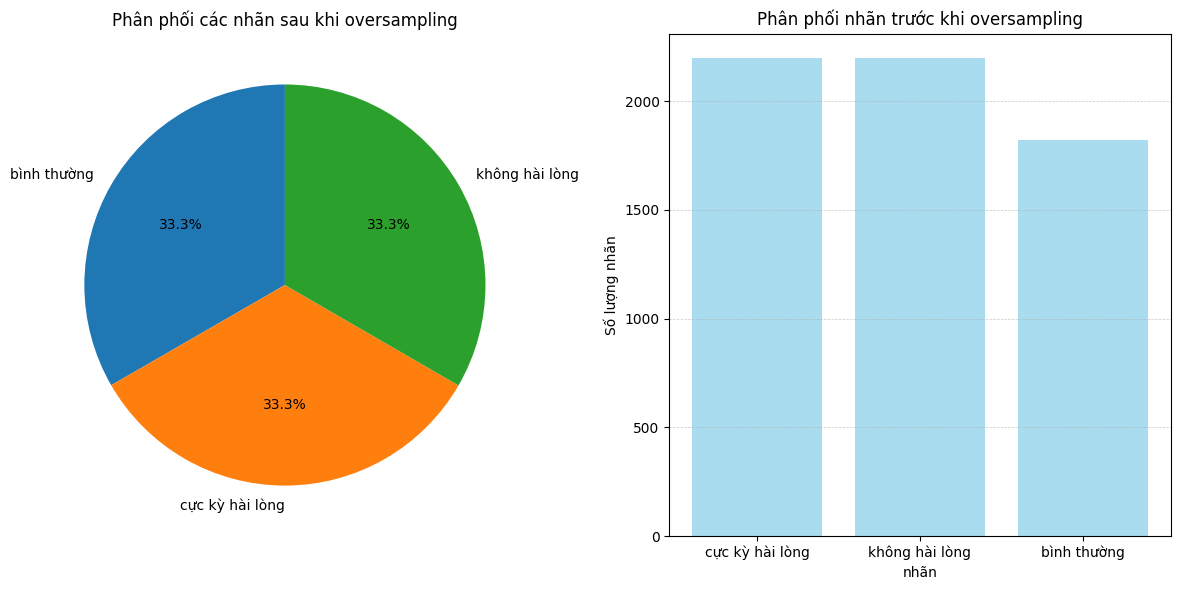

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử `train_labels_oversampled` đã là một list hoặc Series các nhãn string (VD: "không hài lòng", "bình thường", "cực kỳ hài lòng")
label_counts_oversampled = pd.Series(train_labels_oversampled).value_counts().sort_index()
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Pie chart cho label sau khi oversample
labels = label_counts_oversampled.index.tolist()  # tự động lấy tên nhãn từ dữ liệu
ax[0].pie(label_counts_oversampled, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].set_title('Phân phối các nhãn sau khi oversampling')

# Bar chart cho topic (nếu bạn có)
topics = df_balanced_3_label['title'].value_counts().index.tolist()
topic_counts = df_balanced_3_label['title'].value_counts().values
ax[1].bar(topics, topic_counts, alpha=0.7, color='skyblue')
ax[1].set_title('Phân phối nhãn trước khi oversampling')
ax[1].set_xlabel('nhãn')
ax[1].set_ylabel('Số lượng nhãn')
ax[1].grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


# Text Feature

##Trích xuất đặc trưng cho Machine Learning.

###`CountVectorizer` (scikit-learn)

#### Mục tiêu:
Biểu diễn câu thành vector đặc trưng theo dạng
- **Bag-of-Words**: đếm số lần mỗi từ xuất hiện trong câu.
- **Vị trí từ**: Không quan tâm
- **Phù hợp**: Machine
- **Đầu ra**: Ma trận đếm từ

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Vectorizer cho tập 3 nhãn
vectorizer_3 = CountVectorizer()
vectorizer_3.fit(train_sentences_3_label)
X_train_3_label = vectorizer_3.transform(train_sentences_3_label)
X_test_3_label = vectorizer_3.transform(test_sentences_3_label)
Y_train_3_label = train_labels_3_label
Y_test_3_label = test_labels_3_label

# Vectorizer cho tập 2 nhãn
vectorizer_2 = CountVectorizer()
vectorizer_2.fit(train_sentences_2_label)
X_train_2_label = vectorizer_2.transform(train_sentences_2_label)
X_test_2_label = vectorizer_2.transform(test_sentences_2_label)
Y_train_2_label = train_labels_2_label
Y_test_2_label = test_labels_2_label


###TF-IDF (Term Frequency - Inverse Document Frequency)

####Giới thiệu:

TF-IDF là phương pháp biểu diễn văn bản dựa trên tần suất xuất hiện của từ trong câu (TF) và tần suất ngược của từ trong toàn bộ tập dữ liệu (IDF).

- **Vị trí từ**: Không quan tâm.

- **Phù hợp**: Phân loại văn bản, tìm kiếm thông tin.

- **Đầu ra**: Ma trận đặc trưng, trong đó mỗi cột là trọng số của từ dựa trên TF và IDF.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizer cho tập 3 nhãn (TF-IDF)
vectorizer_3_tfidf = TfidfVectorizer()
vectorizer_3_tfidf.fit(train_sentences_3_label)
X_train_3_label = vectorizer_3_tfidf.transform(train_sentences_3_label)
X_test_3_label = vectorizer_3_tfidf.transform(test_sentences_3_label)

# Vectorizer cho tập 2 nhãn (TF-IDF)
vectorizer_2_tfidf = TfidfVectorizer()
vectorizer_2_tfidf.fit(train_sentences_2_label)
X_train_2_label = vectorizer_2_tfidf.transform(train_sentences_2_label)
X_test_2_label = vectorizer_2_tfidf.transform(test_sentences_2_label)


In [ ]:
!pip install tensorflow

# Machine Learning model

##Hàm huấn luyện mô hình

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

def train_and_evaluate_model(model, X_train, Y_train, X_test, Y_test, model_name="Mô hình", label_type=""):
    # Huấn luyện
    model.fit(X_train, Y_train)

    # Dự đoán
    Y_pred = model.predict(X_test)

    # Đánh giá
    acc = accuracy_score(Y_test, Y_pred)
    prec = precision_score(Y_test, Y_pred, average='weighted')
    rec = recall_score(Y_test, Y_pred, average='weighted')
    f1 = f1_score(Y_test, Y_pred, average='weighted')
    cm = confusion_matrix(Y_test, Y_pred)

    # In kết quả
    print(f"\n ===== {model_name.upper()} ({label_type}) =====")
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(Y_test, Y_pred))
    print("Confusion Matrix:\n", cm)

    # Trả kết quả thống kê để vẽ biểu đồ
    return {
        "model": model,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm
    }


##Hàm trực quan so sánh kết quả mô hình

In [ ]:
def def_truc_quan(ket_qua_dict, label_type="", Y_test=None):
    # Sắp xếp mô hình theo accuracy giảm dần
    sorted_models = sorted(ket_qua_dict.items(), key=lambda x: x[1]['accuracy'], reverse=True)

    # Tạo danh sách các mô hình đã sắp xếp
    models = [model for model, _ in sorted_models]
    accuracy = [ket_qua_dict[model]['accuracy'] for model in models]

    # Chọn màu sắc ngẫu nhiên cho từng mô hình
    colors = sns.color_palette("Set2", len(models))

    # Vẽ biểu đồ cột ngang với nhiều màu
    plt.figure(figsize=(8, 5))
    bars = plt.barh(models, accuracy, color=colors)
    plt.xlabel('Accuracy')
    plt.title(f'So sánh Accuracy giữa các mô hình ({label_type})')
    plt.xlim(0, 1)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Hiển thị giá trị accuracy trên mỗi thanh
    for bar, acc in zip(bars, accuracy):
        plt.text(acc + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{acc:.2f}', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Nếu có Y_test thì lấy tên nhãn từ Y_test
    if Y_test is not None:
        label_names = np.unique(Y_test)  # Lấy tên nhãn tự động từ Y_test

    # Vẽ ma trận nhầm lẫn cho từng mô hình
    for model in models:
        if 'confusion_matrix' in ket_qua_dict[model]:
            cm = ket_qua_dict[model]['confusion_matrix']
            plt.figure(figsize=(4, 3))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=label_names,
                        yticklabels=label_names)
            plt.title(f'Confusion Matrix - {model} ({label_type})')
            plt.xlabel('Dự đoán')
            plt.ylabel('Thực tế')
            plt.tight_layout()
            plt.show()


##Thực hiện và so sánh mô hình

#### 2 nhãn

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

result_nb_2 = train_and_evaluate_model(MultinomialNB(),
                                       X_train_2_label,
                                       Y_train_2_label,
                                       X_test_2_label,
                                       Y_test_2_label, model_name="Naive Bayes", label_type="2 nhãn")
result_rf_2 = train_and_evaluate_model(RandomForestClassifier(),
                                       X_train_2_label,
                                       Y_train_2_label,
                                       X_test_2_label,
                                       Y_test_2_label, model_name="Random Forest", label_type="2 nhãn")

result_lr_2 = train_and_evaluate_model(LogisticRegression(max_iter=1000),
                                       X_train_2_label,
                                       Y_train_2_label,
                                       X_test_2_label,
                                       Y_test_2_label, model_name="Logistic Regression", label_type="2 nhãn")

result_svm_2 = train_and_evaluate_model(SVC(kernel='linear', random_state=42),
                                       X_train_2_label,
                                       Y_train_2_label,
                                       X_test_2_label,
                                       Y_test_2_label, model_name="SVM", label_type="2 nhãn")

# Gom kết quả thành dict
ket_qua_2_nhan = {
    "Naive Bayes": result_nb_2,
    "Random Forest": result_rf_2,
    "Logistic Regression": result_lr_2,
    "SVM": result_svm_2
}


 ===== NAIVE BAYES (2 nhãn) =====
Accuracy: 0.8558692421991084
Classification Report:
                  precision    recall  f1-score   support

cực kỳ hài lòng       0.88      0.84      0.86       688
 không hài lòng       0.84      0.88      0.86       658

       accuracy                           0.86      1346
      macro avg       0.86      0.86      0.86      1346
   weighted avg       0.86      0.86      0.86      1346

Confusion Matrix:
 [[576 112]
 [ 82 576]]

 ===== RANDOM FOREST (2 nhãn) =====
Accuracy: 0.8580980683506686
Classification Report:
                  precision    recall  f1-score   support

cực kỳ hài lòng       0.89      0.82      0.86       688
 không hài lòng       0.83      0.90      0.86       658

       accuracy                           0.86      1346
      macro avg       0.86      0.86      0.86      1346
   weighted avg       0.86      0.86      0.86      1346

Confusion Matrix:
 [[565 123]
 [ 68 590]]

 ===== LOGISTIC REGRESSION (2 nhãn) =====
Accur

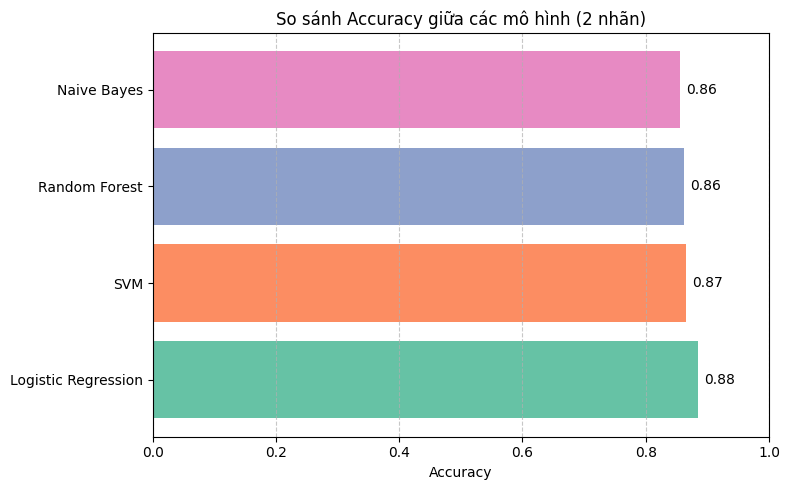

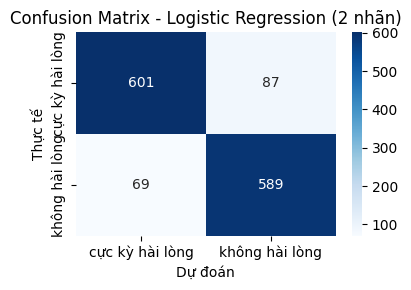

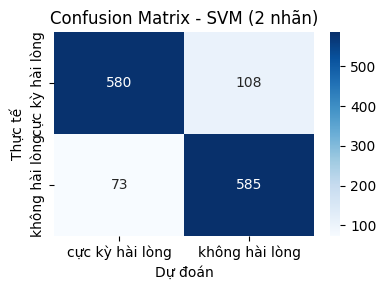

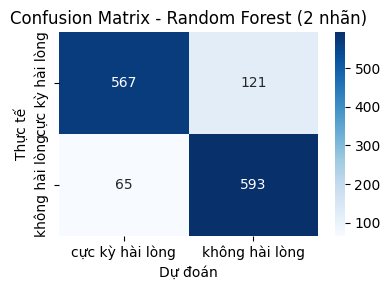

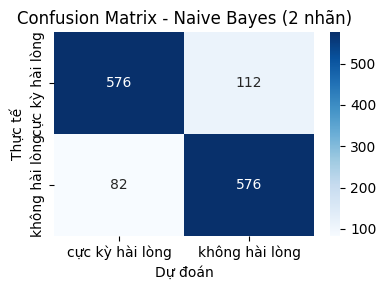

In [ ]:
def_truc_quan(ket_qua_2_nhan, label_type="2 nhãn", Y_test=Y_test_2_label)

####3 nhãn


 ===== NAIVE BAYES (3 nhãn) =====
Accuracy: 0.6468699839486356
Classification Report:
                  precision    recall  f1-score   support

    bình thường       0.46      0.42      0.44       172
cực kỳ hài lòng       0.79      0.76      0.77       226
 không hài lòng       0.63      0.71      0.67       225

       accuracy                           0.65       623
      macro avg       0.63      0.63      0.63       623
   weighted avg       0.64      0.65      0.64       623

Confusion Matrix:
 [[ 72  25  75]
 [ 38 171  17]
 [ 45  20 160]]

 ===== RANDOM FOREST (3 nhãn) =====
Accuracy: 0.6629213483146067
Classification Report:
                  precision    recall  f1-score   support

    bình thường       0.52      0.38      0.44       172
cực kỳ hài lòng       0.75      0.81      0.78       226
 không hài lòng       0.65      0.73      0.69       225

       accuracy                           0.66       623
      macro avg       0.64      0.64      0.64       623
   weighted

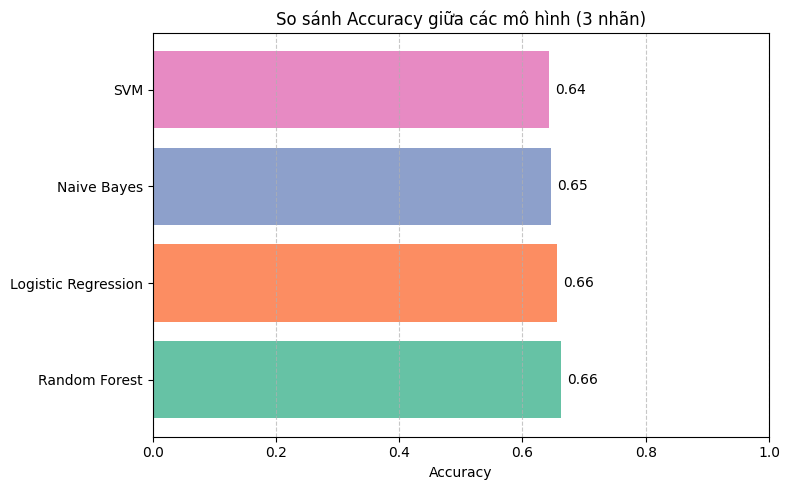

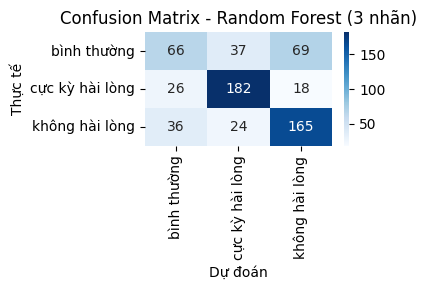

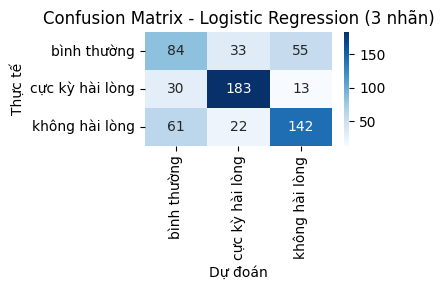

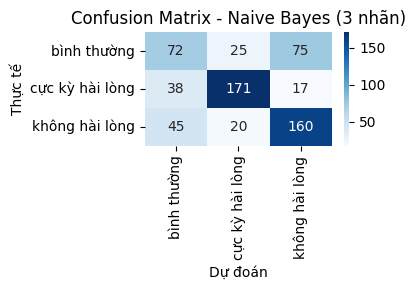

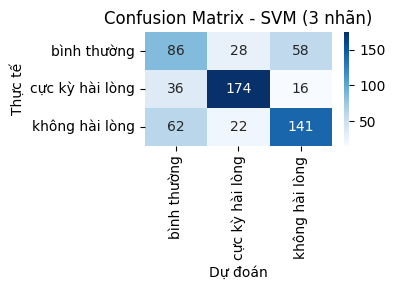

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

# Cập nhật tập dữ liệu 3 nhãn
result_nb_3 = train_and_evaluate_model(MultinomialNB(),
                                       X_train_3_label,  # Cập nhật dữ liệu 3 nhãn
                                       Y_train_3_label,  # Cập nhật dữ liệu 3 nhãn
                                       X_test_3_label,   # Cập nhật dữ liệu 3 nhãn
                                       Y_test_3_label,   # Cập nhật dữ liệu 3 nhãn
                                       model_name="Naive Bayes",
                                       label_type="3 nhãn")

result_rf_3 = train_and_evaluate_model(RandomForestClassifier(),
                                       X_train_3_label,
                                       Y_train_3_label,
                                       X_test_3_label,
                                       Y_test_3_label,
                                       model_name="Random Forest",
                                       label_type="3 nhãn")

result_lr_3 = train_and_evaluate_model(LogisticRegression(max_iter=1000),
                                       X_train_3_label,
                                       Y_train_3_label,
                                       X_test_3_label,
                                       Y_test_3_label,
                                       model_name="Logistic Regression",
                                       label_type="3 nhãn")

result_svm_3 = train_and_evaluate_model(SVC(kernel='linear', random_state=42),
                                       X_train_3_label,
                                       Y_train_3_label,
                                       X_test_3_label,
                                       Y_test_3_label,
                                       model_name="SVM",
                                       label_type="3 nhãn")

# Gom kết quả thành dict cho 3 nhãn
ket_qua_3_nhan = {
    "Naive Bayes": result_nb_3,
    "Random Forest": result_rf_3,
    "Logistic Regression": result_lr_3,
    "SVM": result_svm_3
}

# Gọi hàm trực quan hóa (đã được cập nhật với các mô hình mới)
def_truc_quan(ket_qua_3_nhan, label_type="3 nhãn",  Y_test=Y_test_3_label)


#Test mô hình

In [ ]:
# Câu cần dự đoán
cau_test = "Tạm được đi"

cau_test = clean_data(cau_test)

# Vector hóa câu (sử dụng CountVectorizer đã fit trước đó)
X_cau_test_2 = vectorizer_2.transform([cau_test])
X_cau_test_3 = vectorizer_3.transform([cau_test])


ket_qua_2 = result_lr_2['model'].predict(X_cau_test_2)

ket_qua_3 = result_rf_3['model'].predict(X_cau_test_3)

print(cau_test)

print("Kết quả dự đoán của 2 nhãn:", ket_qua_2[0])
print("Kết quả dự đoán của 3 nhãn:", ket_qua_3[0])


tạm được đi
Kết quả dự đoán của 2 nhãn: không hài lòng
Kết quả dự đoán của 3 nhãn: bình thường


In [ ]:

# Danh sách các từ khóa cần tìm
keywords = ["không ok", "không ổn", "không tốt"]
# Lọc các hàng có nhãn 'cực kỳ hài lòng' và 'không hài lòng'
happy_df = df_balanced_2_label[df_balanced_2_label['title'] == 'cực kỳ hài lòng']
unhappy_df = df_balanced_2_label[df_balanced_2_label['title'] == 'không hài lòng']

# Đếm số lượng các từ khóa xuất hiện trong cột 'clean_content' của các hàng có nhãn 'cực kỳ hài lòng'
count_keywords_happy = {keyword: happy_df['clean_content'].str.contains(keyword, case=False, na=False).sum() for keyword in keywords}

# Đếm số lượng các từ khóa xuất hiện trong cột 'clean_content' của các hàng có nhãn 'không hài lòng'
count_keywords_unhappy = {keyword: unhappy_df['clean_content'].str.contains(keyword, case=False, na=False).sum() for keyword in keywords}

# Hiển thị kết quả
print("Cực kỳ hài lòng:", count_keywords_happy)
print("Không hài lòng:", count_keywords_unhappy)


Cực kỳ hài lòng: {'không ok': np.int64(0), 'không ổn': np.int64(6), 'không tốt': np.int64(11)}
Không hài lòng: {'không ok': np.int64(0), 'không ổn': np.int64(42), 'không tốt': np.int64(78)}
